# Task 3: Customer Segmentation / Clustering

In [1]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Load the datasets
customers_path = "Customers.csv"
transactions_path = "Transactions.csv"

customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

# Convert dates to datetime format for feature engineering
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

# Step 1: Aggregate transaction data for clustering features
customer_clustering_features = transactions_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Transaction count
    'ProductID': lambda x: x.nunique()  # Unique products purchased
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'ProductID': 'UniqueProducts'
})

# Add region as a categorical feature using one-hot encoding
region_dummies = pd.get_dummies(customers_df.set_index('CustomerID')['Region'], prefix='Region')

# Combine transaction and region features
customer_clustering_features = customer_clustering_features.join(region_dummies)

# Step 2: Normalize features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_clustering_features)

# Convert scaled features back to a DataFrame for clarity
scaled_features_df = pd.DataFrame(scaled_features, index=customer_clustering_features.index, columns=customer_clustering_features.columns)


## Determine Optimal Number of Clusters

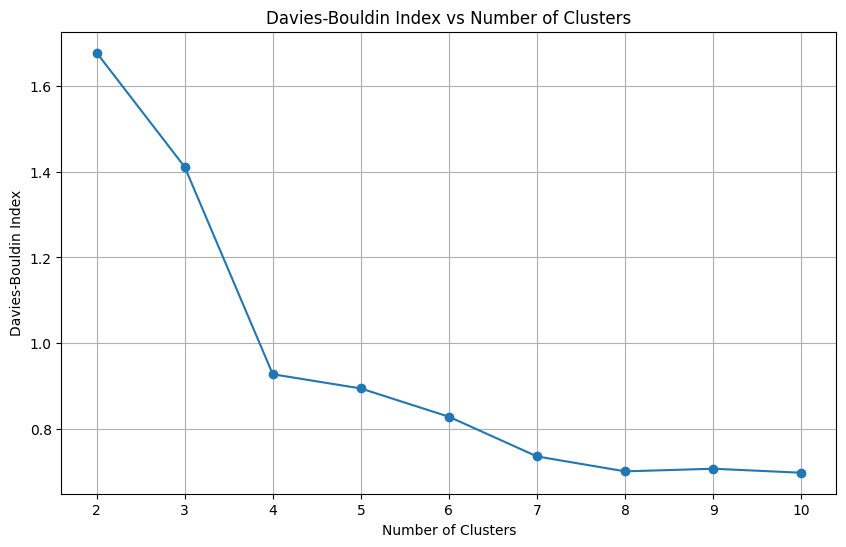

Optimal number of clusters: 10


In [2]:

# Step 1: Initialize variables to store clustering metrics
db_scores = []
clusters_range = range(2, 11)  # Testing clusters from 2 to 10

# Step 2: Perform clustering for different numbers of clusters
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores.append(db_index)

# Step 3: Plot Davies-Bouldin Index for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, db_scores, marker='o')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.grid(True)
plt.show()

# Determine optimal number of clusters
optimal_clusters = clusters_range[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_clusters}")


## Perform Clustering with Optimal Number of Clusters

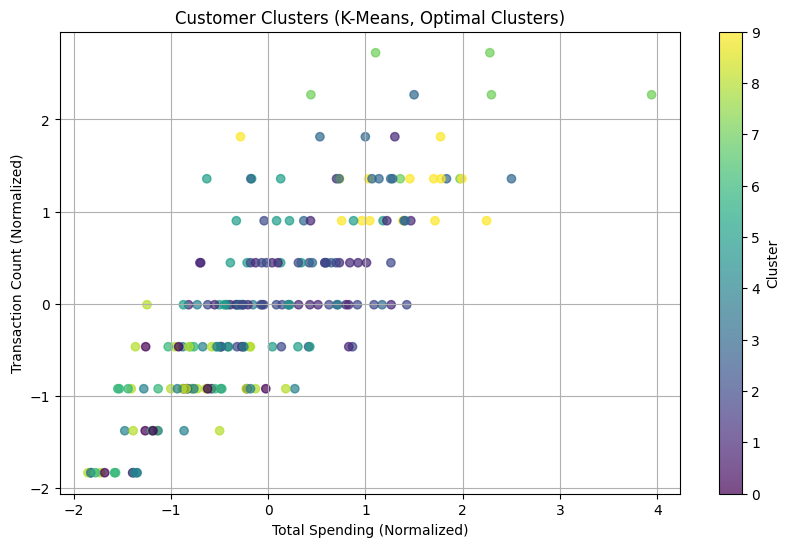

In [3]:

# Step 1: Perform K-Means clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(scaled_features)

# Step 2: Add cluster labels to the original DataFrame
customer_clustering_features['Cluster'] = cluster_labels

# Step 3: Visualize the clusters (scatter plot of the first two numerical features)
plt.figure(figsize=(10, 6))
plt.scatter(scaled_features_df['TotalSpending'], scaled_features_df['TransactionCount'], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("Customer Clusters (K-Means, Optimal Clusters)")
plt.xlabel("Total Spending (Normalized)")
plt.ylabel("Transaction Count (Normalized)")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


## Analyze Cluster Characteristics

In [4]:

# Step 1: Analyze cluster characteristics
cluster_analysis = customer_clustering_features.groupby('Cluster').mean()

# Step 2: Add customer count per cluster
cluster_analysis['CustomerCount'] = customer_clustering_features['Cluster'].value_counts()

# Display the cluster analysis results
print(cluster_analysis)


         TotalSpending  TransactionCount  UniqueProducts  Region_Asia  \
Cluster                                                                 
0          1831.780000          2.733333        2.733333          0.0   
1          4180.902222          5.814815        5.777778          0.0   
2          3959.377857          5.250000        5.142857          0.0   
3          5379.353889          7.500000        7.055556          1.0   
4          2124.869231          3.192308        3.115385          1.0   
5          3470.239600          5.800000        5.800000          0.0   
6          1558.390000          2.882353        2.823529          0.0   
7          6964.940000          9.714286        9.428571          0.0   
8          1940.745455          3.045455        2.954545          0.0   
9          5856.953571          7.714286        7.214286          0.0   

         Region_Europe  Region_North America  Region_South America  \
Cluster                                              